In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.eos import State as StateEoS
from feos_pcsaft.eos import PhaseEquilibrium as PhaseEquilibriumEoS
from feos_pcsaft.dft import *
# from feos_pcsaft.dft import *
# from feos_pcsaft.feos_pcsaft import *
import glob
#import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/venv_entropyscaling/lib/python3.8/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

In [2]:
components = ['propane']#, 'butane']#, 'pentane']
composition = np.array([0.5, 0.5]) *MOL
temperature = 210.15* KELVIN
pressure = 1 * BAR

In [3]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
eos = PcSaft(params)

In [4]:
if len(components) == 1:
    t_crit = StateEoS.critical_point_pure(eos)[0].temperature
    vleEoS = PhaseEquilibriumEoS.pure_t(eos, temperature)
else:
    t_crit = StateEoS.critical_point(eos, composition).temperature
    vleEoS = PhaseEquilibriumEoS.bubble_point_tx(eos, temperature, composition/MOL)
vleEoS

||temperature|density|
|-|-|-|
|phase 1|210.15000 K|21.11622  mol/m³|
|phase 2|210.15000 K|13.64952 kmol/m³|


In [5]:
print(vleEoS.liquid.viscosity())
print(vleEoS.vapor.viscosity())


249.07038554129383 µPas
5.61065359133366 µPas


In [6]:
params = PcSaftParameters.from_json(components, '../parameters/propane_with_entropy_scaling.json')
func = PcSaftFunctional(params)
func_hs = (params)
params

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|propane|44.0962|2.0018290000000003|3.618353|208.1101|0|0|0|0|1|1|

In [7]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|210.15000 K|21.11622  mol/m³|
|phase 2|210.15000 K|13.64952 kmol/m³|


In [8]:
# PLANAR INTERFACE
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit)

In [9]:
# PORE 1D
potential  = ExternalPotential.LJ93(2.5, 40.0, 0.08)
interface = Pore1D(func, Geometry.Cartesian, 50*ANGSTROM, potential, 512).initialize(vle.liquid)

In [10]:
solver = DFTSolver(output=False).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
density_init = interface.density
interface.solve(solver, debug=False)   

In [11]:
# print(interface.surface_tension)

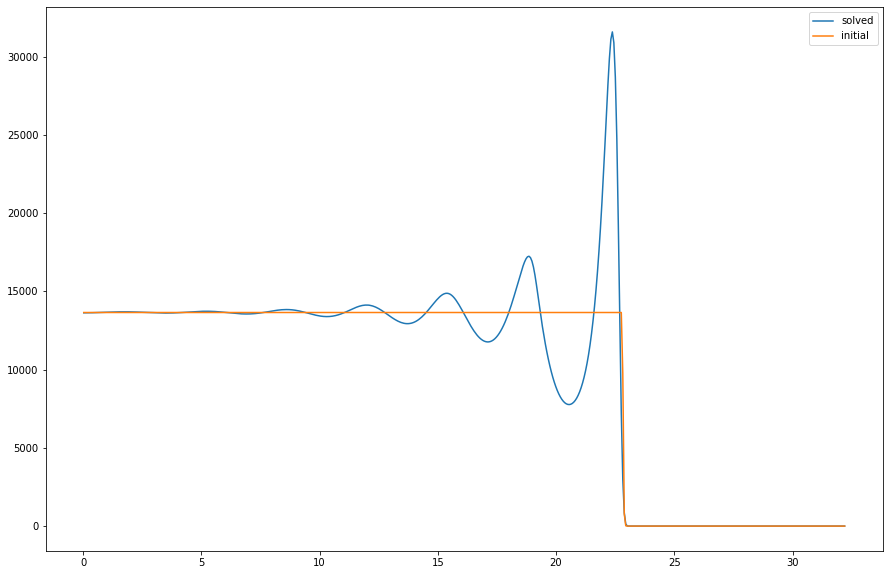

In [12]:
plt.figure(figsize=[15,10])
plt.plot(interface.z/ANGSTROM, (interface.density/MOL*METER**3)[0], label='solved')
plt.plot(interface.z/ANGSTROM, (density_init/MOL*METER**3)[0], label='initial')
# plt.plot(interface.z/ANGSTROM, (interface.weighted_densities[0])[0,:], label='wd')
plt.legend()

In [13]:
print(interface.viscosity_profile[0])
print(interface.viscosity_profile[-1])

thread '<unnamed>' panicked at 'internal error: entered unreachable code', /usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/weight_functions.rs:74:50
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: internal error: entered unreachable code

In [14]:
plt.figure(figsize=[15,10])

plt.plot(interface.z/ANGSTROM, interface.viscosity_profile/MICRO/PASCAL/SECOND)
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND, vleEoS.liquid.viscosity()/MICRO/PASCAL/SECOND])
plt.plot([interface.z[0]/ANGSTROM, interface.z[-1]/ANGSTROM], [vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND, vleEoS.vapor.viscosity()/MICRO/PASCAL/SECOND])


thread '<unnamed>' panicked at 'internal error: entered unreachable code', /usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/weight_functions.rs:74:50


PanicException: internal error: entered unreachable code

<Figure size 1080x720 with 0 Axes>

In [28]:
#plt.plot(interface.z/ANGSTROM, interface.entropy_density)

(1, 512)
(1, 512)


Text(0, 0.5, '$\\rho$')

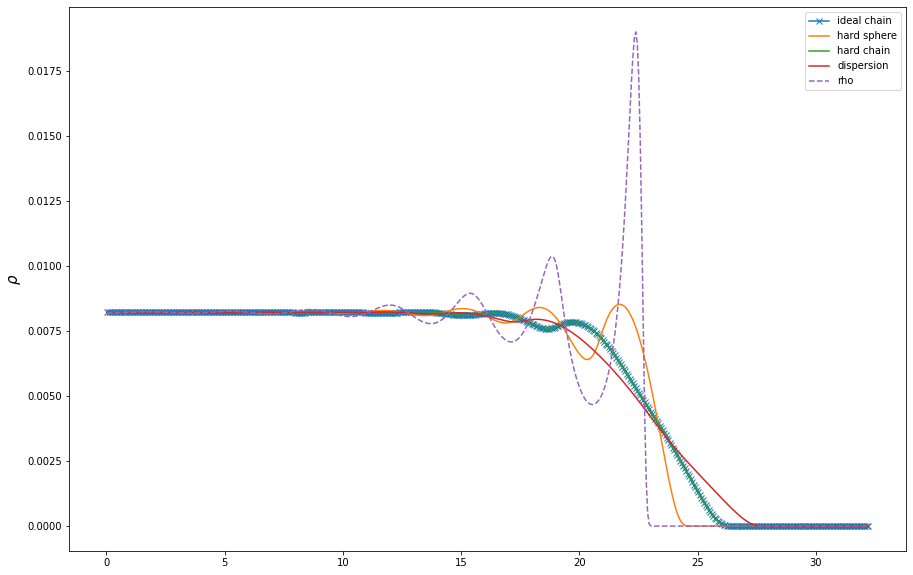

In [29]:
plt.figure(figsize=[15,10])
    
# for filename in glob.glob('*wd_entropy.npy'):
#     data = np.load(filename)    
#     print(f'data shape = {data.shape}')
#     for j in range(data.shape[0]):
#         plt.plot(interface.z / ANGSTROM, (data)[j,:], label=f'wd rho {j}')#, marker = 'x')

data = np.load('0_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'ideal chain', marker = 'x')
print(data.shape)

data_hs = np.load('1_wd_entropy.npy')
print(data_hs.shape)
plt.plot(interface.z / ANGSTROM, (data_hs)[0,:], label=f'hard sphere')#, marker = 'x')

data = np.load('2_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'hard chain')#, marker = 'x')

data = np.load('3_wd_entropy.npy')
plt.plot(interface.z / ANGSTROM, (data)[0,:], label=f'dispersion')#, marker = 'x')

plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho', linestyle='--')

# plt.plot(interface.z/ANGSTROM, (interface.weighted_densities[0])[1,:], label='rho', linestyle='--')
plt.legend()
plt.ylabel(r'$\rho$', fontsize=15)

Text(0, 0.5, '$s^{res}_{contrib}(r)$')

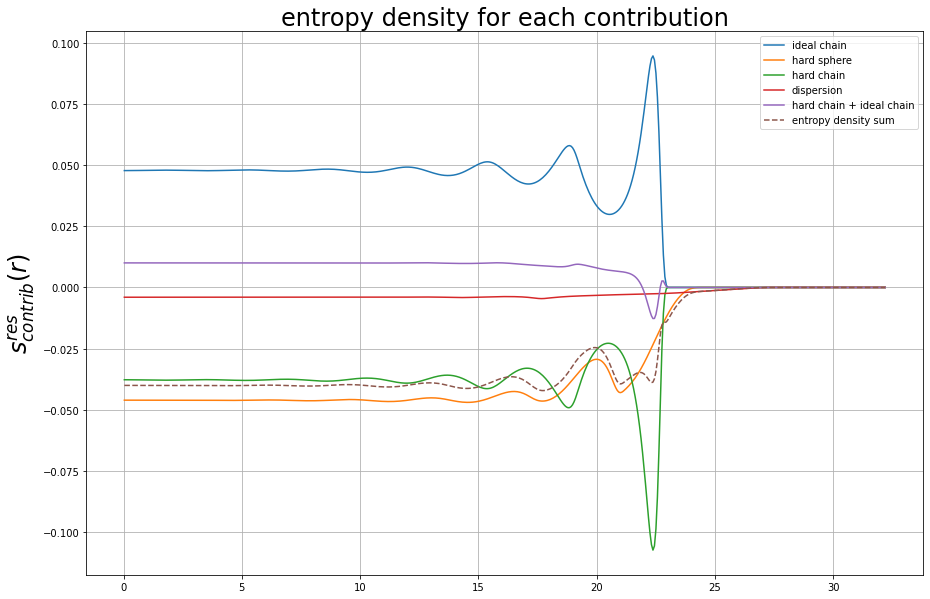

In [30]:
plt.figure(figsize=[15,10])
entropy_density = np.zeros((interface.z/ANGSTROM).shape[0])

# for filename in glob.glob('*edc.npy'):
#     data = np.load(filename)    
#     print(f'data shape = {data.shape}')
    
#     plt.plot(interface.z / ANGSTROM, (data), label=f'entropy_density_contrib')#, marker = 'x')
#     entropy_density = entropy_density + data

data_ic = np.load('0_edc.npy')
plt.plot(interface.z / ANGSTROM, (data_ic), label=f'ideal chain')#, marker = 'x')
entropy_density = entropy_density + data_ic


data_hs = np.load('1_edc.npy')
entropy_density = entropy_density + data_hs
plt.plot(interface.z / ANGSTROM, (data_hs), label=f'hard sphere')#, marker = 'x')

data_hc = np.load('2_edc.npy')
entropy_density = entropy_density + data_hc
plt.plot(interface.z / ANGSTROM, (data_hc), label=f'hard chain')#, marker = 'x')

data_disp = np.load('3_edc.npy')
entropy_density = entropy_density + data_disp
plt.plot(interface.z / ANGSTROM, (data_disp), label=f'dispersion')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, (data_hc) + (data_ic), label=f'hard chain + ideal chain')#, marker = 'x')

# plt.plot(interface.z/ANGSTROM, entropy_density, label='entropy density sum', marker='o')
# plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/PASCAL/SECOND, label='entropy sum')
plt.plot(interface.z/ANGSTROM, interface.entropy_density(Contributions.Residual)/RGAS*NAV*ANGSTROM**3, linestyle='--',label='entropy density sum')

#plt.xlim([20, 28])
#plt.ylim([-0.01, 0.01])
plt.legend()
plt.grid()
plt.title('entropy density for each contribution', fontsize=24)
plt.ylabel(r'$s^{res}_{contrib}(r)$', fontsize=24)

In [31]:
plt.figure(figsize=[15,10])
entropy = np.zeros((interface.z/ANGSTROM).shape[0])

data_ic = np.load('0_edc.npy')
data_wd_ic = interface.weighted_densities_entropy[0]
plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')
entropy = entropy +data_ic/data_wd_ic[0,:]

data_hs = np.load('1_edc.npy')
data_wd_hs = interface.weighted_densities_entropy[0]
entropy = entropy + (data_hs)/data_wd_hs[0,:]
plt.plot(interface.z / ANGSTROM, (data_hs)/data_wd_hs[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard \ sphere}}}$')#, marker = 'x')
# plt.plot(interface.z / ANGSTROM, (data_hs)/data_wd_hs[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard sphere}}}$')#, marker = 'x')

data_hc = np.load('2_edc.npy')
data_wd_hc = interface.weighted_densities_entropy[2]
entropy = entropy + (data_hc)/data_wd_hc[0,:]
plt.plot(interface.z / ANGSTROM, (data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

data_disp = np.load('3_edc.npy')
data_wd_disp = interface.weighted_densities_entropy[3]
entropy = entropy + (data_disp)/data_wd_disp[0,:]
plt.plot(interface.z / ANGSTROM, (data_disp)/data_wd_disp[0,:], label=r'$\frac{s^{res}_{\mathrm{dispersion}}}{\bar{\rho}_{\mathrm{dispersion}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:]+(data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}} +\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, entropy, label=f'sum')#, marker = 'x')

# plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho')
plt.legend(fontsize=20)
plt.title('entropy density divided by corresponding (weighted) density for each contribution', fontsize=24)
plt.ylabel(r'$\frac{s^{res}}{\bar{\rho}}$', fontsize=24)
plt.ylim([-20,20])

thread '<unnamed>' panicked at 'internal error: entered unreachable code', /usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/weight_functions.rs:74:50


PanicException: internal error: entered unreachable code

<Figure size 1080x720 with 0 Axes>

In [32]:
plt.figure(figsize=[15,10])
entropy = np.zeros((interface.z/ANGSTROM).shape[0])

data_ic = np.load('1_edc.npy')
data_wd_ic = interface.weighted_densities_entropy[0]
plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')
entropy = entropy +data_ic/data_wd_ic[0,:]

data_hs = np.load('1_edc.npy')
data_wd_hs = interface.weighted_densities_entropy[1]
entropy = entropy + (data_hs)/data_wd_hs[0,:]
plt.plot(interface.z / ANGSTROM, (data_hs)/data_wd_hs[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard \ sphere}}}$')#, marker = 'x')
# plt.plot(interface.z / ANGSTROM, (data_hs)/data_wd_hs[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ sphere}}}{\bar{\rho}_{\mathrm{hard sphere}}}$')#, marker = 'x')

data_hc = np.load('1_edc.npy')
data_wd_hc = interface.weighted_densities_entropy[2]
entropy = entropy + (data_hc)/data_wd_hc[0,:]
plt.plot(interface.z / ANGSTROM, (data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

data_disp = np.load('1_edc.npy')
data_wd_disp = interface.weighted_densities_entropy[3]
entropy = entropy + (data_disp)/data_wd_disp[0,:]
plt.plot(interface.z / ANGSTROM, (data_disp)/data_wd_disp[0,:], label=r'$\frac{s^{res}_{\mathrm{dispersion}}}{\bar{\rho}_{\mathrm{dispersion}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, data_ic/data_wd_ic[0,:]+(data_hc)/data_wd_hc[0,:], label=r'$\frac{s^{res}_{\mathrm{ideal\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}} +\frac{s^{res}_{\mathrm{hard\ chain}}}{\bar{\rho}_{\mathrm{hard\ chain}}}$')#, marker = 'x')

plt.plot(interface.z / ANGSTROM, entropy, label=f'sum')#, marker = 'x')

# plt.plot(interface.z/ANGSTROM, (interface.density*NAV*ANGSTROM**3)[0,:], label='rho')
plt.legend(fontsize=20)
plt.title('test for fmt contrib', fontsize=24)
plt.ylabel(r'$\frac{s^{res}}{\bar{\rho}}$', fontsize=24)


thread '<unnamed>' panicked at 'internal error: entered unreachable code', /usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/weight_functions.rs:74:50


PanicException: internal error: entered unreachable code

<Figure size 1080x720 with 0 Axes>

In [33]:
interface.entropy_density(Contributions.Residual)/((interface.density/MOL*METER**3)[0,:]*MOL/METER**3)

[-40.52094088079982, -40.520142405015854, -40.51855145840803, -40.51618004866807, -40.51304618311932, ..., -58893.88865420171, -58842.63289363021, -58805.48843637466, -58783.12682285943, -58779.00275835062] J/mol/K

In [34]:
interface.entropy_density(Contributions.Residual)/(((interface.density*NAV*ANGSTROM**3)[0,:])/NAV/ANGSTROM**3)/RGAS

array([-4.87354899e+00, -4.87345295e+00, -4.87326161e+00, -4.87297639e+00,
       -4.87259947e+00, -4.87213374e+00, -4.87158279e+00, -4.87095095e+00,
       -4.87024325e+00, -4.86946539e+00, -4.86862380e+00, -4.86772556e+00,
       -4.86677837e+00, -4.86579058e+00, -4.86477108e+00, -4.86372933e+00,
       -4.86267522e+00, -4.86161911e+00, -4.86057165e+00, -4.85954380e+00,
       -4.85854666e+00, -4.85759144e+00, -4.85668931e+00, -4.85585129e+00,
       -4.85508818e+00, -4.85441037e+00, -4.85382778e+00, -4.85334966e+00,
       -4.85298453e+00, -4.85274001e+00, -4.85262270e+00, -4.85263807e+00,
       -4.85279035e+00, -4.85308237e+00, -4.85351555e+00, -4.85408972e+00,
       -4.85480312e+00, -4.85565230e+00, -4.85663208e+00, -4.85773556e+00,
       -4.85895405e+00, -4.86027717e+00, -4.86169281e+00, -4.86318723e+00,
       -4.86474517e+00, -4.86634991e+00, -4.86798342e+00, -4.86962657e+00,
       -4.87125925e+00, -4.87286061e+00, -4.87440933e+00, -4.87588381e+00,
       -4.87726249e+00, -

In [35]:
entropy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [51]:
for wds in interface.weighted_densities_entropy:
    print(wds.shape)

thread '<unnamed>' panicked at 'internal error: entered unreachable code', /usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/weight_functions.rs:74:50


PanicException: internal error: entered unreachable code